Exercise 1: Molecular Dynamics
Write a program that simulates a gas of point-like particles in the microcanonical ensemble
(fixed E, N, V) with periodic boundary conditions in 3D. All particles should have identical mass m.
• Use only the Lennard–Jones potential to drive the movement of the particles, no other forces.
The force vector between a pair of particles i, j reads:
$$\vec{f}(r_{ij})=\frac{24\epsilon}{r_{ij}}\left(2\left(\frac{\sigma}{r_{ij}}\right)^{12}-\left(\frac{\sigma}{r_{ij}}\right)^{6}\right)\frac{\vec{x_{j}}-\vec{x_{i}}}{||\vec{x_{j}}-\vec{x_{i}}||}$$
where $$r_{ij}=||\vec{x_{j}}-\vec{x_{i}}||$$.
• Use reduced units, m = 1, ε = 1, σ = 1.
• Set the box size to Lx = Ly = Lz = 10, the number of particles to N = 100, the timestep to h = 1e-3, and simulate from tstart = 0 to tend = 50.
But start with only few (e.g., 3) particles first, to test your program.
• To keep it simple, compute the interaction force between all particle pairs i ≠ j.
(See Bonus #2 for the advanced method, which is more complicated to program.)
• As an initial condition, place all particles randomly in the simulation box, and set their velocity to zero. To avoid huge initial forces, all particles should have an initial separation of rij ≥ 0.9σ. Check this while adding more particles. If a new particle is too close to an existing one, place it at another random position.
• Use a symplectic time integration method to move the particles.
• Measure the performance of your simulation. How many particle steps (number of timesteps multiplied by the number of particles) can you run per second on your computer?
• Measure and plot the temperature T = 2K/(3kB(N − 1)) of the ensemble over time, where K
is the kinetic energy (see lecture notes). Use reduced units, kB = 1. What do you observe?

Bonus #1: Create an animation/video of your MD simulation, showing how the particles move.

FileNotFoundError: [WinError 2] The system cannot find the file specified

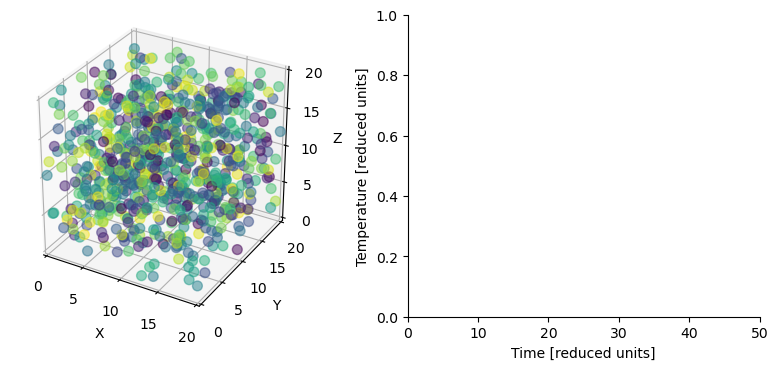

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

np.random.seed(0)

N = 800  # number of particles
L = np.array([20, 20, 20])  # simulation box size (reduced units)
r_min = 0.9  # minimum separation (reduced units)
h = 1e-3  # time step size (reduced units)
t_end = 50  # total simulation time (reduced units)

duration = 10  # video duration in secs
fps = 50  # frames per second
frames = duration * fps  # number of frames
steps_per_frame = int(round(t_end / h / frames))  # timesteps per animation frame

r_cut = 2.5  # interaction cutoff (reduced units)
Nc = np.ceil(L / r_cut).astype(int)  # number of spatial partitioning cells

# initialize the particles
x = np.zeros((3, N))  # position
v = np.zeros((3, N))  # velocity
a = np.zeros((3, N))  # acceleration

i = 0
while i < N:
    x[:, i] = np.random.rand(3) * L
    for j in range(i):
        dx = x[:, j] - x[:, i]
        dx = dx - np.round(dx / L) * L
        if np.dot(dx, dx) < r_min * r_min:
            i -= 1  # particles too close, draw a new random position for it
            break
    i += 1

# video preparation
video = animation.FFMpegWriter(fps=fps)
fig = plt.figure(figsize=(10, 4), dpi=100)
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_xlim3d([0, L[0]])
ax1.set_ylim3d([0, L[1]])
ax1.set_zlim3d([0, L[2]])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_box_aspect((np.ptp(ax1.get_xlim()), np.ptp(ax1.get_ylim()), np.ptp(ax1.get_zlim())))
ax2 = fig.add_subplot(122)
ax2.set_xlim([0, t_end])
ax2.set_ylim([0, 1])
ax2.set_xlabel('Time [reduced units]')
ax2.set_ylabel('Temperature [reduced units]')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

scat = ax1.scatter(x[0], x[1], x[2], s=50, c=np.random.rand(N), alpha=0.5)
line, = ax2.plot([0], [0], linewidth=2)

with video.saving(fig, 'md3.mp4', dpi=100):
    for frame in range(frames):
        for s in range(steps_per_frame):
            # build the linked cell list
            first = np.zeros(tuple(Nc), dtype=int)
            next = np.zeros(N, dtype=int)
            for i in range(N):
                c = np.floor(x[:, i] / r_cut).astype(int)  # 3D cell index of particle i
                next[i] = first[tuple(c)]
                first[tuple(c)] = i

            # reset all accelerations
            a *= 0

            # Lennard-Jones force (reduced units)
            for i in range(N):
                ci = np.floor(x[:, i] / r_cut).astype(int)  # 3D cell index of particle i
                for cjx in range(ci[0] - 1, ci[0] + 2):
                    cjx_mod = cjx % Nc[0]  # apply periodic boundary condition
                    for cjy in range(ci[1] - 1, ci[1] + 2):
                        cjy_mod = cjy % Nc[1]  # apply periodic boundary condition
                        for cjz in range(ci[2] - 1, ci[2] + 2):
                            cjz_mod = cjz % Nc[2]  # apply periodic boundary condition
                            j = first[cjx_mod, cjy_mod, cjz_mod]  # particle j
                            while j != -1:
                                if j < i:  # consider each particle pair only once
                                    dx = x[:, j] - x[:, i]
                                    dx -= np.round(dx / L) * L  # apply periodic boundary condition
                                    r2 = np.dot(dx, dx)
                                    if r2 < r_cut ** 2:
                                        r4 = r2 * r2
                                        r6 = r4 * r2
                                        r8 = r4 * r4
                                        f = 24 / r8 * (2 / r6 - 1) * dx
                                        a[:, i] -= f
                                        a[:, j] += f
                                j = next[j]

            # semi-implicit Euler
            v += h * a
            x += h * v

            # restrict particle positions to simulation box
            x -= np.floor(x / (L * np.ones((N, 3)))).astype(int) * (L * np.ones((N, 3)))

